<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [DCGAN01] - A first DCGAN to Draw a Sheep
<!-- DESC --> Episode 1 : Draw me a sheep, revisited with a DCGAN
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Build and train a DCGAN model with the Quick Draw dataset
 - Understanding DCGAN

The [Quick draw dataset](https://quickdraw.withgoogle.com/data) contains about 50.000.000 drawings, made by real people...  
We are using a subset of 117.555 of Sheep drawings  
To get the dataset : [https://github.com/googlecreativelab/quickdraw-dataset](https://github.com/googlecreativelab/quickdraw-dataset)  
Datasets in numpy bitmap file : [https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap](https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap)   
Sheep dataset : [https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy](https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy) (94.3 Mo)


## What we're going to do :

 - Have a look to the dataset
 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
See : [https://keras.io/examples/](https://keras.io/examples/)


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import DCGAN
from modules.callbacks import ImagesCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/DCGAN.001'                  # Output directory
datasets_dir = pwk.init('DCGAN01', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.24
Notebook id          : DCGAN01
Run time             : Monday 11 October 2021, 15:52:11
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/DCGAN.001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/DCGAN.001/figs


## Step 2 - Parameters

In [2]:
latent_dim = 128

scale      = 1
epochs     = 10
batch_size = 32
num_img    = 12

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'epochs', 'batch_size', 'num_img', 'scale')

## Step 3 - Load dataset and have a look 
Load sheeps as numpy bitmaps...

In [4]:
# Load dataset
x_data = np.load(datasets_dir+'/QuickDraw/origine/sheep.npy')
print(x_data.shape)

# Rescale
n=int(scale*len(x_data))
x_data = x_data[:n]
print(x_data.shape)

# Normalize, reshape and shuffle
x_data = x_data/255
x_data = x_data.reshape(-1,28,28,1)
np.random.shuffle(x_data)
print(x_data.shape)


(126121, 784)
(126121, 784)
(126121, 28, 28, 1)


...and have a look :  
Note : These sheep are sheep drawn ... by real humans!

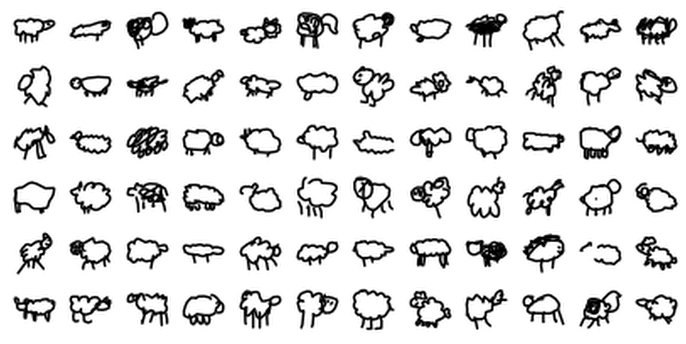

In [5]:
pwk.plot_images(x_data.reshape(-1,28,28), indices=range(72), columns=12, x_size=1, y_size=1, y_padding=0,spines_alpha=0, save_as='01-Sheeps')

## Step 4 - Create a discriminator

In [6]:
inputs  = keras.Input(shape=(28, 28, 1))
x       = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Flatten()(x)
x       = layers.Dropout(0.2)(x)
z       = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.Model(inputs, z, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)       

## Step 5 - Create a generator

In [7]:
# inputs  = keras.Input(shape=(latent_dim,))
# x       = layers.Dense(7 * 7 * 64)(inputs)
# x       = layers.Reshape((7, 7, 64))(x)
# x       = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)
# x       = layers.LeakyReLU(alpha=0.2)(x)
# x       = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same")(x)
# x       = layers.LeakyReLU(alpha=0.2)(x)
# outputs = layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid")(x)




inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64)(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(128,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(256,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
outputs = layers.Conv2D(1,    kernel_size=5, strides=1, padding="same", activation="sigmoid")(x)

generator = keras.Model(inputs, outputs, name="generator")
generator.summary()



Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       29

## Step 6 - Build, compile and train our DCGAN 
First, clean saved images :

In [8]:
!rm $run_dir/images/*.jpg >/dev/null 2>&1 

Build our model :

In [9]:
gan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

Fidle DCGAN is ready :-)  latent dim = 128


In [10]:
gan.compile(
    discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer     = keras.optimizers.Adam(learning_rate=0.0001),
    loss_function           = keras.losses.BinaryCrossentropy(),
)

Add a callback to save images, train our DCGAN model and save it :

In [11]:
imagesCallback = ImagesCallback(num_img=num_img, latent_dim=latent_dim, run_dir=f'{run_dir}/images')

history = gan.fit( x_data, epochs=epochs, batch_size=batch_size, callbacks=[imagesCallback] )

gan.save(f'{run_dir}/models/model.h5')

Epoch 1/10
3942/3942 [==============================] - 33s 7ms/step - d_loss: 0.4719 - g_loss: 1.5369
Epoch 2/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.5246 - g_loss: 1.2451
Epoch 3/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.5717 - g_loss: 1.1026
Epoch 4/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.5940 - g_loss: 1.0557
Epoch 5/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.6026 - g_loss: 1.0187
Epoch 6/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.6031 - g_loss: 1.0122
Epoch 7/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.6072 - g_loss: 0.9956
Epoch 8/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.6059 - g_loss: 0.9919
Epoch 9/10
3942/3942 [==============================] - 29s 7ms/step - d_loss: 0.6026 - g_loss: 1.0028
Epoch 10/10
3942/3942 [==============================] - 29s 7ms/step - d

## Step 7 - History

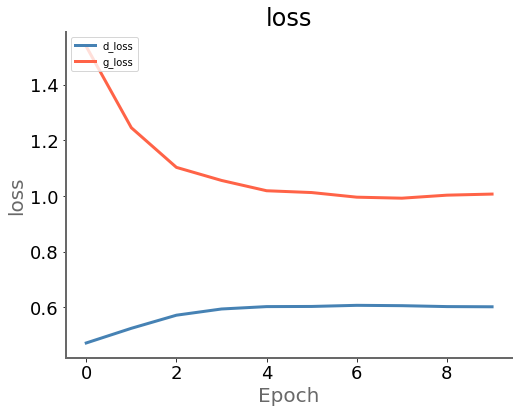

In [12]:
pwk.plot_history(history,  plot={'loss':['d_loss','g_loss']}, save_as='01-history')

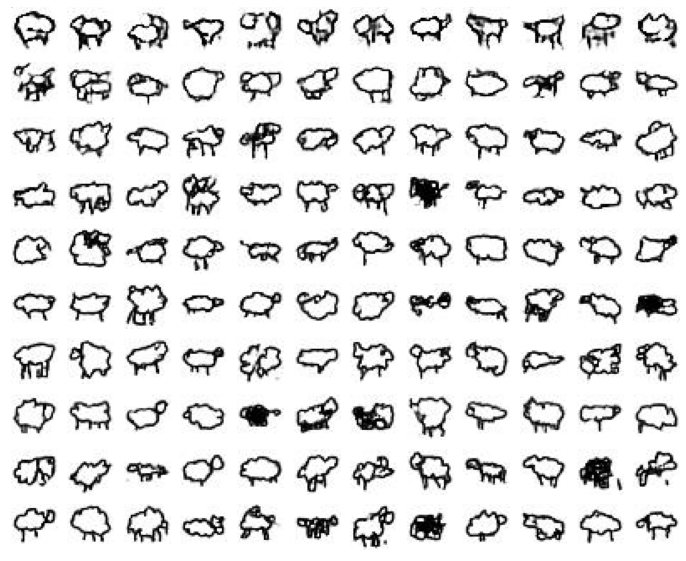

In [13]:
images=[]
for epoch in range(0,epochs,1):
    for i in range(num_img):
        filename = f'{run_dir}/images/image-{epoch:03d}-{i:02d}.jpg'
        image    = io.imread(filename)
        images.append(image)      

pwk.plot_images(images, None, indices='all', columns=num_img, x_size=1,y_size=1, interpolation=None, y_padding=0, spines_alpha=0, save_as='04-learning')

## Step 8 - Generation
Reload our saved model :

In [14]:
gan.reload(f'{run_dir}/models/model.h5')

Reloaded.


Generate somes images from latent space :

In [15]:
nb_images = 12*15

z = np.random.normal(size=(nb_images,latent_dim))
images = gan.predict(z)


Plot it :

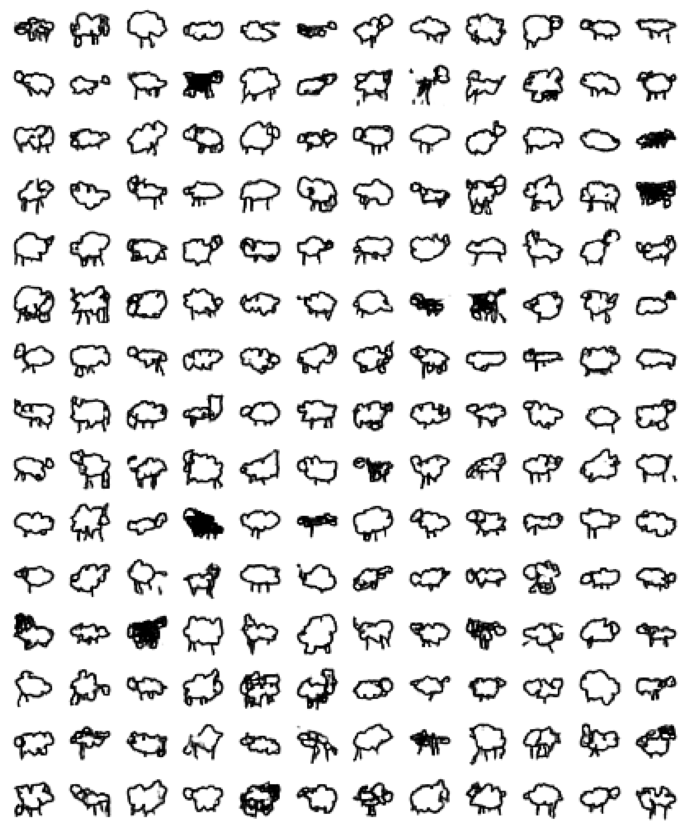

In [16]:
pwk.plot_images(images, None, indices='all', columns=num_img, x_size=1,y_size=1, interpolation=None, y_padding=0, spines_alpha=0, save_as='04-learning')

In [17]:
pwk.end()

End time is : Monday 11 October 2021, 15:57:30
Duration is : 00:05:19 918ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>